Comparing the models (expcet the one in task 4), we can see that the logistic regression model with TFIDF have  remarkable improvement in classifying Not Real disasters in comparison with the other two models where TF_IDF was not used. However, their abilities to predict true values of Real disasters significantly decreased.
Therefore, the logistic regression model with word couts still performs better than other three models in predicting Real disasters. 


#### Import required packageds 

In [115]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegressionCV

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet
from nltk.stem import snowball
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import torch

from collections import defaultdict
from collections import  Counter

import re
import string
from string import digits
import unicodedata
from autocorrect import Speller

from siuba import *
from siuba.dply.forcats import *
from siuba.dply.vector import row_number, lag
import tensorflow as tf

from plotnine import *

import warnings
warnings.filterwarnings("ignore")

import gensim.downloader
#glove_vectors = gensim.downloader.load('glove-twitter-100')


## Taks 1
- Build a bag of words model 
- perfrom all of the pre-processing of the dataset to prepare it for a ag of words model
- explain all of your choices around pre processing 
- train the model and provide plots on the evaluation

In [42]:
## Import train and test sets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [43]:

## convert tweets to lower
## in train dataset generate a new varaible called disater indicating if a tweet is about real disater or not
train = (train 
>> mutate(text = _.text.str.lower())       
>> mutate(disaster = case_when({_.target ==1:"Real Disaster" ,_.target==0:"Not Disaster", True: 99} )))

### Exploratory Data Analaysis

- Proportion of tweets identifed as real disaster
    - About 43% of tweets in training set are about a real disaster. 

In [44]:
# 61 keywords are missing
# 2533 locations are missing 
train.isnull().sum().to_frame().rename(columns={0: "Missing Count"})

,Missing Count
id,0
keyword,61
location,2533
text,0
target,0
disaster,0


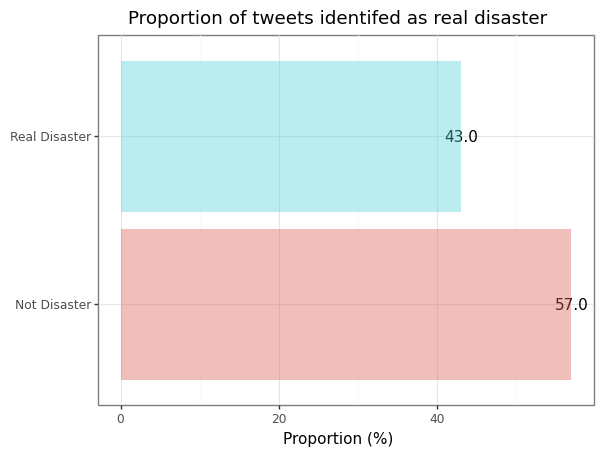

<ggplot: (8781221401116)>

In [45]:
# Is the target balanced?
(train
>> count(_.disaster)
>> mutate(proportion = _.n/_.n.sum()*100)
>> mutate(proportion = _.proportion.round(1))
>> ggplot(aes("disaster","proportion",fill="disaster")) 
 + geom_text(aes(label="proportion"))
 + geom_col(alpha=0.4) 
 + theme_bw() +
 labs(x="",y="Proportion (%)",title="Proportion of tweets identifed as real disaster") +
 theme(legend_position="none") +
 coord_flip()
)

###  List of Words before cleaning
 - Here we explore the data before cleaning 

In [46]:
# generate two lists including the words in tweets
## real disaster
list_train_real = []
for texts in train[train["target"]==1]["text"].str.split():
    for words in texts:
        list_train_real.append(words)

# NOT real 
list_train_not_real = []
for texts in train[train["target"]==0]["text"].str.split():
    for words in texts:
        list_train_not_real.append(words)

## convert to data frame and flag the target
df_list_train_real = (pd.DataFrame(pd.DataFrame({'words':list_train_real})) >> mutate(disaster = "Real"))
df_list_train_not_real = (pd.DataFrame(pd.DataFrame({'words':list_train_not_real})) >> mutate(disaster = "No Real"))

# concat the frames
list_of_words_df = (pd.concat([df_list_train_real,df_list_train_not_real],axis=0))

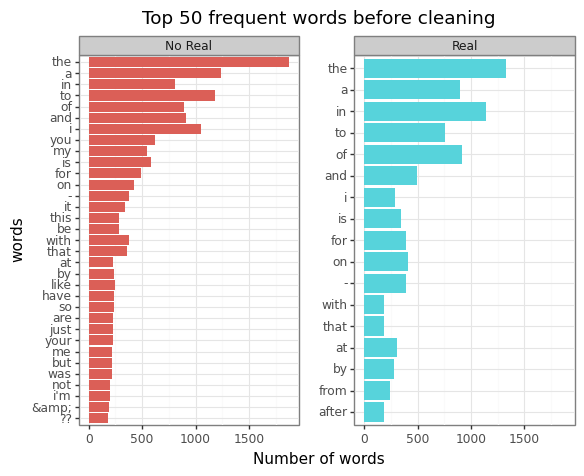

<ggplot: (8781219814087)>

In [48]:
# What are the top 50 frequent words 

before_cleaning_graph =  (list_of_words_df
 >> group_by(_.disaster,_.words)
 >> count(sort=True) 
 >> ungroup()
 >> group_by(_.disaster) 
 >> arrange(-_.n)
 >> ungroup()
 >> filter(row_number(_) <51)
  >> mutate(words = fct_reorder(_.words,_.n))
 >> ggplot(aes("words","n",fill="disaster")) 
 + geom_col() 
 + coord_flip() 
 + facet_wrap("disaster",scales="free_y") 
 + theme_bw() 
 + theme(subplots_adjust={'wspace': 0.25}) 
 + theme(legend_position="none") +
 labs(title="Top 50 frequent words before cleaning",fill="",y="Number of words")
)

before_cleaning_graph

### Data Cleaning
- Here we make a function called "text_pre_processing" encompasing four sub functions to clean the datasets
    - function 1: text_cleaner: this function extracts items such as punctuations, links, accents etc.
    - function 2: clean_nltk_stopwords: this function removes stop words using stop words of nltk package
    - function 3: lemmatizer_nltk: this function lemmatizes the words in tweets. We did not use a stemmer that is based on a series of general rules. Rather I used a lemmatizer that is based on knowledge of English language
    - function 4: spell_correction: this function looks for misspelled words and corrects them. It is a computationally expensive operation, so the user can decide if this function should be applied or not

In [49]:

# 1 text cleaner function
def text_cleaner(text):
    # to lower
    text = str(text).lower()
    
    ## remove hidden characters
    printable = r'\w \!"#\$%&\(\)\*\+,\-\./:;<»«؛،ـ\=>\?@\[\\\]\^_\`\{\|\}~'
    text = text.replace(r'[^{}]+'.format(printable), '')
    
    # replace multuispace with single space
    text = text.replace(r'[ ]+', ' ')

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #remove numbers
    
    text = text.translate(str.maketrans('', '', digits))
    
   # remove links
    
    text = re.sub('http\S+', '', text)
    
    #remove html tags
    text = re.sub('<.*?>', '', text)

    
    # remove words in brackets
    text = re.sub('\[.*?\]', '', text)
    
    # extact emoji patterns and remove them
    def extract_emojis(text):
        emojies = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002500-\U00002BEF"  
            u"\U00002702-\U000027B0"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642" 
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"  
            u"\u3030"
                          "]+", re.UNICODE)
        return re.sub(emojies, '', text)
    
    # Normalize accent characters 

    

   
    def strip_accents(text):
        return ''.join(c for c in unicodedata.normalize('NFD', s)
                       if unicodedata.category(c) != 'Mn')
    
    # add space between word and number 
    text = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", text).strip() 
    
    return(text)



In [50]:
# Remove stop words
def clean_nltk_stopwords(text):
    
    stop_words_nltk = stopwords.words('english')
    
    text = ' '.join(word for word in text.split(' ') if word not in stop_words_nltk)
    return(text)


In [51]:
## Lemmatizer
# use nltk Lemmatizer to lemmatize words. This is especially the case for tweets
# as people might use words based on the context therefore, we should use lemmatizer
# instead of stemming. This is because a lemmatizer is based on the knowledge of a language
# not a set of generalized rules used in stemming 
# import these modules


def lemmatizer_nltk(text):
    
    lemmatizer = WordNetLemmatizer()
   
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return(text)


In [52]:
# as twitter did not have an edit option where this dataset was collected, it is likely that we have misspelling 

def spell_correction(text):
    
    spell=Speller(lang="en")
   
    text = ' '.join(spell(word) for word in text.split(' '))      
    return(text)    


#### Text Preprosseing function

In [53]:
#### Text Preprosseing function using above function
## generting a pre process function including all four functions:
### 1- text_cleaner, clean_nltk_stopwords, lemmatizer_nltk, spell_correction
### it should be noted that as it takes a long time to correct for spelling in this dataset
### we keep the dataset as it is, however, one can use the function below to correct for spelling 

def text_pre_processing(text,correct_for_spelling=False):
    text = text_cleaner(text)
    text = clean_nltk_stopwords(text)
    text = lemmatizer_nltk(text)
    
    if correct_for_spelling == True:
        text = spell_correction(text)
    
    return(text)


In [54]:
# Apply the function text_pre_processing to all tweets 
train_clean = train
clean_text = train["text"].apply(text_pre_processing)
train_clean["clean_text"] = clean_text
train_clean

,id,keyword,location,text,target,disaster,clean_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,Real Disaster,deed reason earthquake may allah forgive u
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,Real Disaster,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,Real Disaster,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Real Disaster,people receive wildfire evacuation order calif...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,Real Disaster,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,Real Disaster,two giant crane holding bridge collapse nearby...
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,Real Disaster,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,Real Disaster,utckm volcano hawaii
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1,Real Disaster,police investigating ebike collided car little...


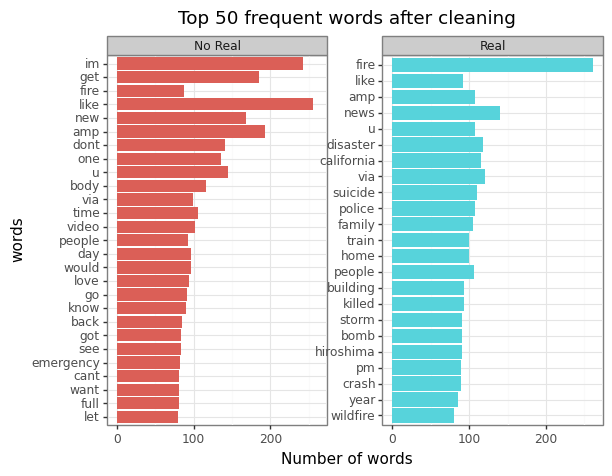

<ggplot: (8781237086468)>

In [56]:
# generate two lists including the words in tweets
## real disaster
list_train_real_clean = []
for texts in train_clean[train_clean["target"]==1]["clean_text"].str.split():
    for words in texts:
        list_train_real_clean.append(words)

# NOT real 
list_train_not_real_clean = []
for texts in train_clean[train_clean["target"]==0]["clean_text"].str.split():
    for words in texts:
        list_train_not_real_clean.append(words)

## convert to data frame and flag the target
df_list_train_real_clean = (pd.DataFrame(pd.DataFrame({'words':list_train_real_clean})) >> mutate(disaster = "Real"))
df_list_train_not_real_clean = (pd.DataFrame(pd.DataFrame({'words':list_train_not_real_clean})) >> mutate(disaster = "No Real"))

# concat the frames
list_of_words_df_clean = (pd.concat([df_list_train_real_clean,df_list_train_not_real_clean],axis=0))

# What are the top 50 frequent words 
## the 
after_cleaning_graph = (list_of_words_df_clean
 >> group_by(_.disaster,_.words)
 >> count(sort=True) 
 >> ungroup()
 >> group_by(_.disaster) 
 >> arrange(-_.n)
 >> ungroup()
 >> filter(row_number(_) <51)
  >> mutate(words = fct_reorder(_.words,_.n))
 >> ggplot(aes("words","n",fill="disaster")) 
 + geom_col() 
 + coord_flip() 
 + facet_wrap("disaster",scales="free_y") 
 + theme_bw() 
 + theme(subplots_adjust={'wspace': 0.25}) 
 + theme(legend_position="none") +
 labs(title="Top 50 frequent words after cleaning",fill="",y="Number of words")
)
after_cleaning_graph

- Comparing the top 50 frequent words before and after cleaning the text is shown below. 
As we can see after cleaning the tweets, the words used in the case of real disaster in tweets are different than the case of not real disaster tweets. 

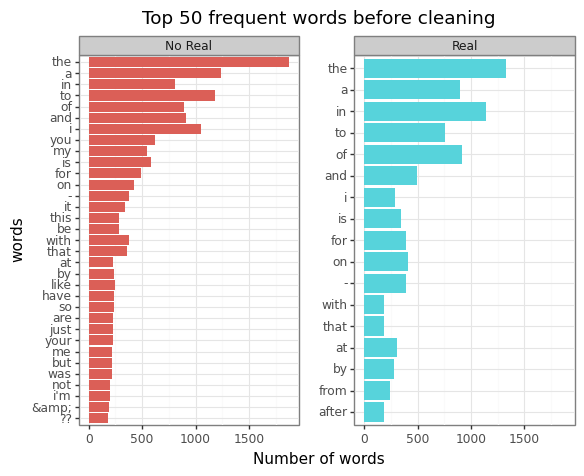

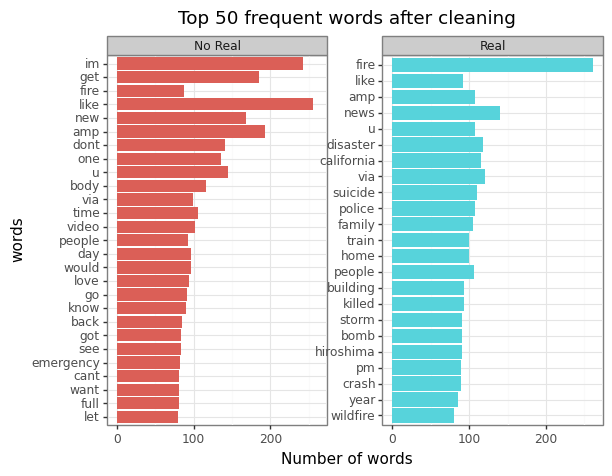

[<ggplot: (8781219814087)>, <ggplot: (8781237086468)>]

In [57]:

graph_to_50 = [before_cleaning_graph,after_cleaning_graph]
graph_to_50 

In [58]:
# bigrams
def get_bigrams(text, n=None):
    vectors = CountVectorizer(ngram_range=(2, 2)).fit(text)
    bag_of_words = vectors.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    freq_of_words = [(word, sum_of_words[0, idx]) for word, idx in vectors.vocabulary_.items()]
    freq_of_words =sorted(freq_of_words, key = lambda x: x[1], reverse=True)
    return freq_of_words[:n]


In [59]:
# apply the get_biagra function
target_real_for_bigram = train_clean[train_clean["target"]==1]["clean_text"]
target_not_real_for_bigram = train_clean[train_clean["target"]==0]["clean_text"]

list_bigram_real = get_bigrams(target_real_for_bigram,20)
list_bigram_not_real = get_bigrams(target_not_real_for_bigram,20)


x_real,y_real=map(list,zip(*list_bigram_real))
x_not_real,y_not_real=map(list,zip(*list_bigram_not_real))




#### Bigram 
As we can see the bigrams are also differnt across the categories of tweets

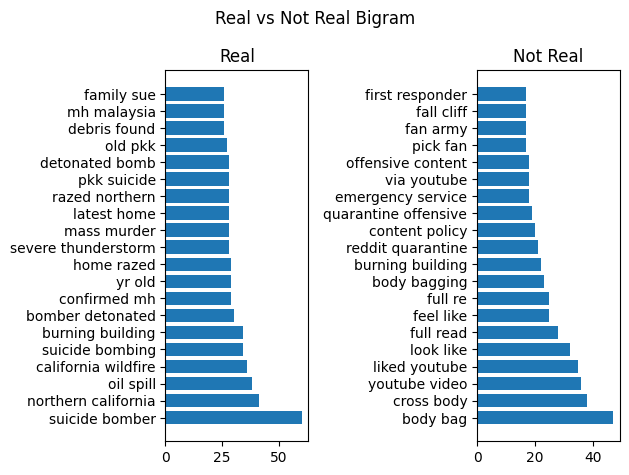

In [63]:
%matplotlib inline
## Bigram plots
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.barh(x_real,y_real)
fig.suptitle('Real vs Not Real Bigram')
ax2.barh(x_not_real,y_not_real)
(ax1, ax2) 
ax1.set_title("Real")
ax2.set_title("Not Real")
fig.tight_layout()


In [64]:
# make the datasets using CountVectorizer

def count_vectorizer_function(text):
    count_vectorizer = CountVectorizer()
    df = count_vectorizer.fit_transform(text)
    return df, count_vectorizer



In [65]:

label_encoder = LabelEncoder()
label_encoder.fit(train_clean['target'])
train_clean['target_encoded'] = label_encoder.transform(train_clean['target'])

list_text_clean = train_clean["clean_text"].tolist()
list_labels = train_clean["target_encoded"].tolist()



X_train, X_test, y_train, y_test = train_test_split(list_text_clean, list_labels, test_size=0.2, 
                                                                                random_state=61)

X_train_counts, count_vectorizer = count_vectorizer_function(X_train)
X_test_counts = count_vectorizer.transform(X_test)

## Fitting a logistic classifier to the data for word counts only 

Accuracy of Logistic Regression Model is = 78.9


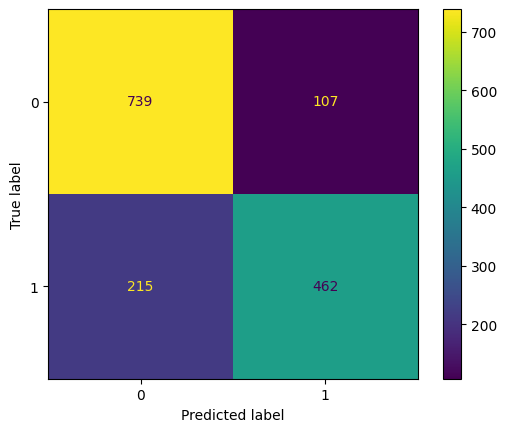

In [67]:
## evaluation



clf = LogisticRegression(n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

def print_metrics(y_test, y_predicted):  
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy

accuracy = print_metrics(y_test, y_predicted_counts)
print("Accuracy of Logistic Regression Model is = %.1f" % (100*accuracy))

# confusion matrix
y_pred = clf.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred)
cm_display_lr = ConfusionMatrixDisplay(cm).plot()

### Fitting a Logistic Regression 
fitting a logisitic regression Model with cross-validation and L1 penalty, improves the accuarcy slightly. 

Accuracy of Logistic Regression Model with cross-validation and L1 penalty is = 79.1


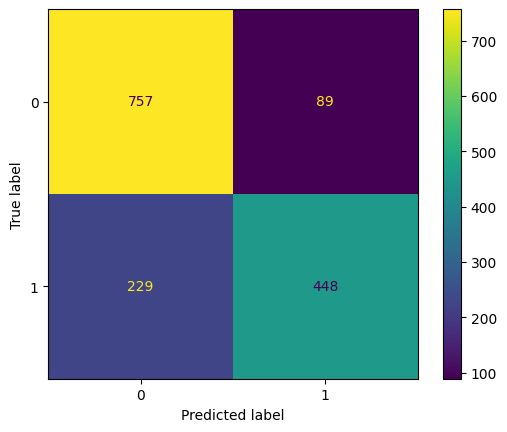

In [68]:


clf_lr_cv = LogisticRegressionCV(cv = 10,scoring='neg_log_loss',penalty='l1', solver='liblinear', multi_class='ovr')

clf_lr_cv.fit(X_train_counts, y_train)

y_predicted_counts = clf_lr_cv.predict(X_test_counts)

accuracy = print_metrics(y_test, y_predicted_counts)
print("Accuracy of Logistic Regression Model with cross-validation and L1 penalty is = %.1f" % (100*accuracy))

y_pred = clf_lr_cv.predict(X_test_counts)
cm_lr_cv = confusion_matrix(y_test, y_pred)

cm_display_lr_csv = ConfusionMatrixDisplay(cm_lr_cv).plot()

### TFID 

In [71]:
def tf_idf(text):
    tf_ifd_vectorizer = TfidfVectorizer()
    train = tf_ifd_vectorizer.fit_transform(text)
    return train, tf_ifd_vectorizer


In [72]:
X_train_tf_idf , tf_ifd_vectorizer = tf_idf(X_train)
X_test_tf_idf = tf_ifd_vectorizer.transform(X_test)



### Logistic Regression TF-IDF

Accuracy of Logistic Regression Model for TF IDF is = 79.1


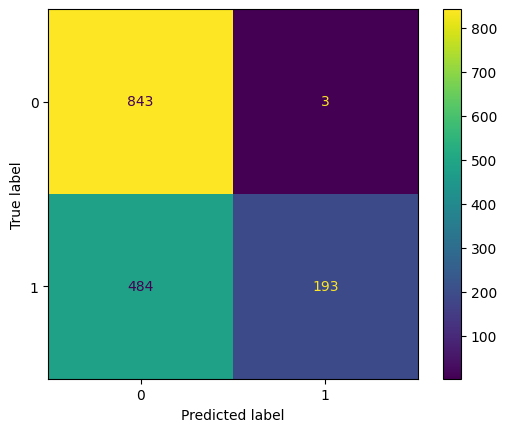

In [75]:
clf_tf_id = LogisticRegression(n_jobs=-1, random_state=40)
clf_tf_id.fit(X_train_tf_idf, y_train)

y_predicted_tf_idf = clf.predict(X_test_tf_idf)

def print_metrics(y_test, y_predicted_tf_idf):  
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted_tf_idf)
    return accuracy

accuracy = print_metrics(y_test, y_predicted_counts)
print("Accuracy of Logistic Regression Model for TF IDF is = %.1f" % (100*accuracy))

# confusion matrix
y_pred = clf_tf_id.predict(X_test_counts)
cm_tf_idf = confusion_matrix(y_test, y_predicted_tf_idf)
cm_display_tf_idf = ConfusionMatrixDisplay(cm_tf_idf).plot()

### TF_IDF  with cross-valdated LogisticRegression

Accuracy of Logistic Regression Model with cross-validation and L1 penalty for TFIDF is = 62.5


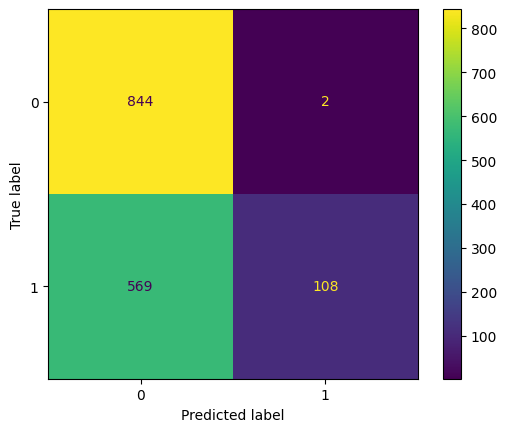

In [76]:
clf_lr_cv_tf_idf = LogisticRegressionCV(cv = 10,scoring='neg_log_loss',penalty='l1', solver='liblinear', multi_class='ovr')

#clf_lr_cv_tf_idf.fit(X_train_tf_idf, y_train)

y_predicted_cv_tf_idf = clf_lr_cv.predict(X_test_tf_idf)

accuracy = print_metrics(y_test, y_predicted_cv_tf_idf)
print("Accuracy of Logistic Regression Model with cross-validation and L1 penalty for TFIDF is = %.1f" % (100*accuracy))

y_pred = clf_lr_cv.predict(X_test_tf_idf)
cm_lr_cv_tf_idf = confusion_matrix(y_test, y_predicted_cv_tf_idf)

cm_display_lr_csv_tf_idf = ConfusionMatrixDisplay(cm_lr_cv_tf_idf).plot()



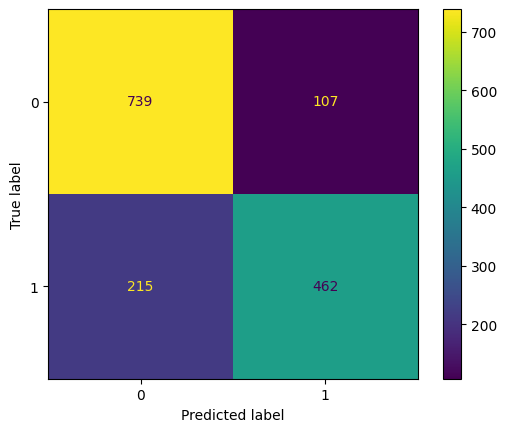

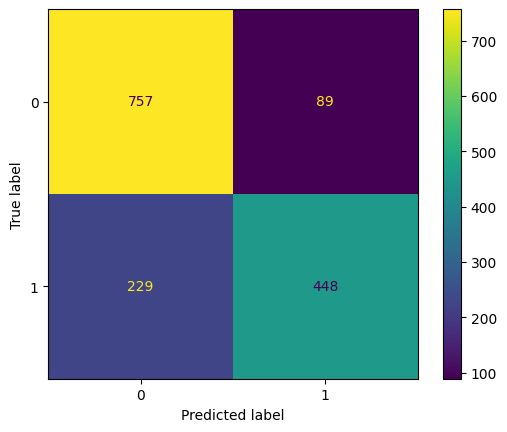

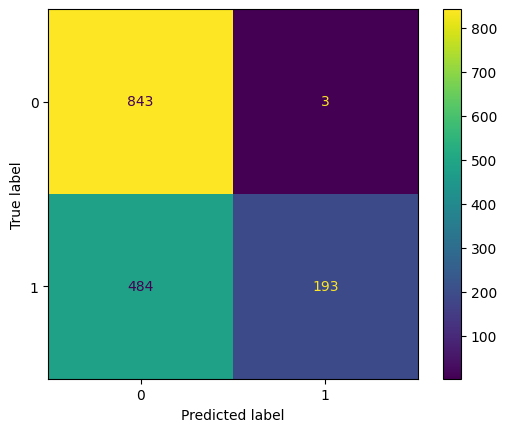

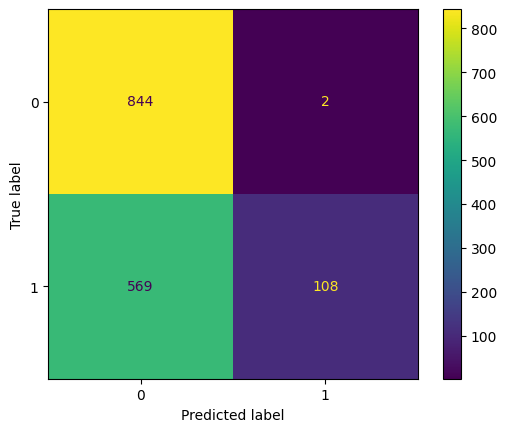

In [77]:
#confustion matrices

[cm_display_lr.plot(), cm_display_lr_csv.plot(), cm_display_tf_idf.plot(),cm_display_lr_csv_tf_idf.plot()]


The logistic regression model with TFIDF have  remarkable improvement in classifying Not Real disasters in comparison with the other two models where TF_IDF was not used. However, their abilities to predict true values of Real disasters significantly decreased.
Therefore, the logistic regression model with word couts still performs better than other three models in predicting Real disasters. 


## GloVe